# Synthesising music from a 2D Quantum Cellular Automaton

This tutorial follows on from the tutorial `pqca_to_midi`. In this tutorial we will be using a more complicated automaton, and a correspondingly more complicated music synthesis procedure.

We will be using `music21` to turns notes into chords into MusicXML.

In [1]:
import music21
import math
import midiutil

## Starting classically

Before constructing the automaton we will show how we will turn its output into music. We will be using a variant on the [CAMUS procedure](https://link.springer.com/chapter/10.1007/978-1-84628-600-1_8) to generate music, but all that will be explained below. We will be working with *grids* of bits of shape $9 \times 4$.
We aren't really using a bitstring anymore, now that it's 2D, but we will work analogously to the 1D case, and here is a bit generator that creates classically-random grids of bits of the right shape.

In [2]:
import random
class Bit_Generator:
    def __next__(self):
        return [[random.choice([0,1]) for i in range(0,9)] for j in range(0,4)]
BG = Bit_Generator()

In [5]:
next(BG)

[[0, 1, 1, 1, 1, 0, 1, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 1, 1, 1, 1],
 [0, 1, 0, 1, 1, 1, 1, 0, 0]]

## Drawing this state

In earlier examples we had a _one dimensional_ automaton, meaning the state was a list of 0s and 1s. We then draw subsequent states of the automaton as subsequent rows down the page.
Now that we have a _two dimensional_ state we will be drawing just one state at a time as a grid of squares.

So that we can clearly indicate certain squares we will want to be able to draw coloured markers on the squares. The function below draws out this grid and also marks any squares passed via the `marked` argument.

In [46]:
import drawsvg
def draw_bits(nine_by_four_bits, marked=None, mark_colour=None):
    """Draw the bits as a shaded grid, marking special points"""
    # Understanding this code is not important to the tutorial
    square_size = 20 # in pixels
    drawing = drawsvg.Drawing(square_size*9, square_size*4)
    for row in range(4):
        for index, bit in enumerate(nine_by_four_bits[row]):
            colour = '#00e000' if bit else '#e10000'
            rect = drawsvg.Rectangle(index*square_size,(3-row)*square_size,square_size,square_size, fill=colour)
            drawing.append(rect)
    if marked is None:
        marked = []
    for index, mark in enumerate(marked):
        # Mark each coordinate in the list `marked`
        x = mark[0]
        y = mark[1]
        colour = "#11f" if mark_colour is None else mark_colour
        circle = drawsvg.Circle((x+0.5)*square_size,(3.5-y)*square_size,square_size/6, fill=colour)
        drawing.append(circle)
    return drawing

Let's draw three of these, each drawing shows a single state of 9 by 4 bits. The first has no marked squares.

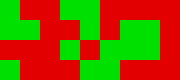

In [41]:
draw_bits(next(BG))

For the next one we will mark point `[0,0]`, which is the top left hand corner. Recall that arrays start at 0 in python.

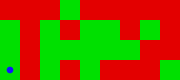

In [42]:
draw_bits(next(BG), [[0,0]])

And for this one we will mark `[1,1]` which is one in and one down from the top left, and also `[8,3]` which is the bottom right hand corner.

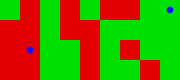

In [43]:
draw_bits(next(BG), [[1,1], [8,3]])

# From a grid of bits to music

Here we describe (a variant on) the CAMUS protocol for music synthesis.

Each grid will determine _a sequence of triads_, rather than a single chord as in the 1D case. How many triads depends on how many $1$s are in the relevant part of the grid. This grid will be split into three parts:
 - The first column dictates the fundamental of this sequence of triads
 - The next 4 columns describe a sequence of triads by way of intervals above the fundamental
 - The final 4 columns describe which instrument will play the notes

The timings of the voices in the triads will be determined in a way we cover later on.

![A diagram showing how the grid of bits is split under CAMUS](images/split_CAMUS.svg)

## Showing this on a grid

To illustrate this we will fix an example 9 by 4 grid.

[[1, 0, 1, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 1, 1, 0, 0, 1],
 [0, 1, 1, 1, 0, 1, 0, 1, 1],
 [1, 0, 0, 1, 0, 1, 0, 0, 1]]

What does this look like?

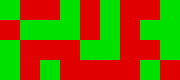

In [57]:
draw_bits(example_bits)

These bits determine the fundamental:

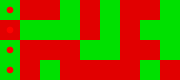

In [56]:
draw_bits(example_bits, [[0, row] for row in range(0,4)], "red")

This 4 by 4 subgrid determines the triads.

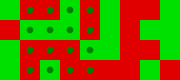

In [163]:
draw_bits(example_bits, [[column, row] for column in range(1,5) for row in range(0,4)], "green")

This final 4 by 4 subgrid determines the instruments.

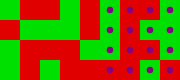

In [134]:
draw_bits(example_bits, [[column, row] for column in range(5,9) for row in range(0,4)], "purple")

## Using the bits directly

Let's break this grid into sections. We'll explain each part in detail afterwards.

In [52]:
def bit_breakdown(four_by_nine_bits):
    """Split the large grid into appropriate subgrids."""
    return {"fundamental": [row[0] for row in four_by_nine_bits],
            "triads": [row[1:5] for row in four_by_nine_bits],
            "instruments": [row[5:9] for row in four_by_nine_bits],
    }

In [58]:
bit_breakdown(example_bits)

{'fundamental': [1, 1, 0, 1],
 'triads': [[0, 1, 0, 0], [0, 0, 0, 1], [1, 1, 1, 0], [0, 0, 1, 0]],
 'instruments': [[0, 0, 1, 0], [1, 0, 0, 1], [1, 0, 1, 1], [1, 0, 0, 1]]}

### What's the fundamental

The fundamental is determined by the four bits in the first column, giving us 16 options.
Each option will correspond to a number of semitones above our `base` note, which defaults to C4 ("low C").
For example:
 - The sequence `[0, 0, 0, 0]` corresponds to the base note
 - `[0, 0, 0, 1]` corresponds to one semitone above the base note
 - `[1, 0, 1, 0]` corresponds to 10 semitones above the base note

In [59]:
def breakdown_to_semitone_shift(bits):
    """Treat the sequence of bits as though it were a binary number."""
    return int("".join(map(str, bits)),2)

In [60]:
breakdown_to_semitone_shift(bit_breakdown(example_bits)["fundamental"])

13

In [162]:
30*math.pow(30,10*2.5/16)

6097.098556371644

In [161]:
math.log(5000,30)

2.504174923024876

### What are the triads

According to the CAMUS protocol each _live_ cell (i.e. a 1) in the grid will be turned into a triad in the following way:
 - the x coordinate of the cell gives the interval between the fundamental and the first note
 - the y coordinate of the cell gives the interval between the first and second notes


These `x` and `y` coordinates are measured from the top-left square in the `triads` section of the grid.

![How we measure the x and y coordinate of a cell in the triads section of the grid](images/xy_CAMUS.svg)

The first thing we will need is a list of all the live cells in the grid. Here's our example grid with the `triad` cells marked.

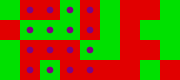

In [61]:
draw_bits(example_bits, [[column, row] for column in range(1,5) for row in range(0,4)], "purple")

Our function will take in the triad bits and return a sequnce of coordinates. These return coordinates are measured from the top left triad bit, not from the top left bit of the overall grid.

In [62]:
def triad_bits_to_coordinate_sequence(triad_bits):
    """Given just the triad subgrid get the coordinates of each live cell."""
    triads = []
    for j in range(0, len(triad_bits)):
        for i in range(0,len(triad_bits[j])):
            if triad_bits[j][i]:
                triads.append([i,j])
    return triads

In [66]:
bit_breakdown(example_bits)["triads"]

[[0, 1, 0, 0], [0, 0, 0, 1], [1, 1, 1, 0], [0, 0, 1, 0]]

In [63]:
triad_bits_to_coordinate_sequence(bit_breakdown(example_bits)["triads"])

[[1, 0], [3, 1], [0, 2], [1, 2], [2, 2], [2, 3]]

Let's double check by marking these on our grid. Note that the reported coordinates are measured from the top left of the `triad` sub-grid, and so we need to shift these coordinates over to overlay them on the entire grid.

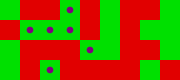

In [67]:
draw_bits(example_bits, map(lambda xy: [xy[0]+1,xy[1]], triad_bits_to_coordinate_sequence(bit_breakdown(example_bits)["triads"])), "purple")

You should see that every light-grey square inside the triads subgrid has a marker on it.

For each of these we want to generate a triad.

In [68]:
def intervals_to_triad(fundamental, coordinate):
    """Turn a single coordinate into the appropriate triad formed above the given fundamental."""
    notes = []
    notes.append(fundamental)
    notes.append(notes[0] + coordinate[0]) # x coordinate determines first interval
    notes.append(notes[1] + coordinate[1]) # y coordinate determines second interval
    return notes

As an example: A triad based on a fundamental of 0, at point `[2,1]` has first note 0 (base) then up two semitones to the next note, then up one semitone to the next note.

In [69]:
intervals_to_triad(0,[2,1])

[0, 2, 3]

We can then use list comprehension to send a list of triad coordinates to a list of triads.

In [70]:
def triad_interval_sequence(bits):
    """Given the large grid of bits provide a sequence of triads."""
    breakdown = bit_breakdown(bits)
    fundamental = breakdown_to_semitone_shift(breakdown["fundamental"])
    triad_bit_sequence = triad_bits_to_coordinate_sequence(breakdown["triads"])
    return [intervals_to_triad(fundamental, coordinate) for coordinate in triad_bit_sequence]

In [71]:
triad_interval_sequence(example_bits)

[[13, 14, 14],
 [13, 16, 17],
 [13, 13, 15],
 [13, 14, 16],
 [13, 15, 17],
 [13, 15, 18]]

We now have a list of triads expressed as semitones above low C.

### Neighbours

In what follows we are going to need to look up the values of cells arround our target cell. Quite apart from it being useful to have a function to do this we also need to specify what happens if we look up a cell outside the range of our grid. In these instances we will simply return the value `0`.

In [72]:
def lookup(bit_grid, coordinates):
    """Find the value at the specified point in the bit_grid.
    
    If the coordinates fall outside of the grid then return 0.
    """
    if coordinates[1] < 0 or coordinates[1] >= len(bit_grid):
        return 0
    if coordinates[0] < 0 or coordinates[0] >= len(bit_grid[0]):
        return 0
    return bit_grid[coordinates[1]][coordinates[0]]

Here are the bits again:

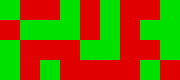

In [73]:
draw_bits(example_bits)

What's the value of the top left bit?

In [74]:
lookup(example_bits, [0,0])

1

What is the value of the bit one across and two down?

In [75]:
lookup(example_bits, [1,2])

1

Now let's mark on the grid both a target point and all its neighbours.

In [76]:
def draw_neighbours(bits, point):
    """Draw the grid of bits and mark all cells surrounding and including the named point."""
    return draw_bits(bits, [[x,y] for x in range(point[0]-1,point[0]+2) for y in range(point[1]-1,point[1]+2)])

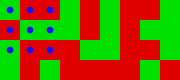

In [77]:
draw_neighbours(example_bits,[1,2])

The CAMUS protocol assigns names to the eight neighbours, and so we will do the same.

 - `a` is North
 - `b` is South
 - `c` is East
 - `d` is West
 - `m` is North-West
 - `n` is South-East
 - `o` is North-East
 - `p` is South-West

![The names of the neighbours of a cell in CAMUS](images/neighbours_CAMUS.svg)

We don't want the *coordinates* of the neighbours as much as the values of the neighbours.

In [97]:
def neighbours(bit_grid, coordinate):
    """For the specified point in the grid return a dictionary of names to cell values.
    
    The names for the neighbours are from the CAMUS specification.
    """
    x_mid = coordinate[0]
    y_mid = coordinate[1]
    ordered = [lookup(bit_grid,[x,y]) 
            for y in (y_mid-1, y_mid, y_mid+1)
            for x in (x_mid-1, x_mid, x_mid+1)
           ]
    return {
        "a": ordered[7],
        "b": ordered[1],
        "c": ordered[5],
        "d": ordered[3],
        "m": ordered[6],
        "n": ordered[2],
        "o": ordered[8],
        "p": ordered[0]
    }

In [98]:
neighbours(example_bits,[1,2])

{'a': 0, 'b': 0, 'c': 1, 'd': 0, 'm': 1, 'n': 0, 'o': 0, 'p': 1}

We will refer to these neighbours just using these single-letter names in what follows.

### Instrumentation

The CAMUS protocol comes with a couple of optional variations, and we will use one where the notes of each triad can be played on different instruments. We choose the instruments by thinking of the `triad` and `instrument` subgrids of our bit-grid as two separate grids. We move through the points (x,y) looking at the value in both grids. The first grid determines whether the triad (fundamental, fundamental + x, fundamental+x+y) is played. The second grid determines which instruments play the triad. To allow us to have multiple instruments we will use the following scheme:
 - neighbour `a` determines if the bottom note is on instrument 0 or 1
 - neighbour `b` determines if the middle note is on instrument 0 or 1
 - neighbour `c` determines if the top note is on instrument 0 or 1

As an example let's assume that cell `[2,1]` in the triad subgrid has value `1`. We look at the corresponding cell in the instrumentation subgrid, and then look at that cell's neighbours.

To show this in action we will pick a point in the `triads` grid and see the corresponding neighbours in the `instrumentation` grid.

![Moving from the triad subgrid to the instrumentation subgrid](images/instrumentation_CAMUS.svg)

Let's make some functions so we can see this on our grid of example bits.

In [164]:
def mark_triad_and_instrument(bits, triad_coord):
    """Mark the cell determining the intervals, and the cells determining the instrumentation on the same grid."""
    return draw_bits(bits, [[triad_coord[0]+1, triad_coord[1]],
                            [triad_coord[0]+5, triad_coord[1]+1],
                            [triad_coord[0]+6, triad_coord[1]],
                            [triad_coord[0]+5, triad_coord[1]-1]])

Remember that the triad coordinate indicates the location just inside the `triad` subgrid, which starts at the second column.

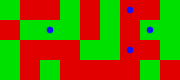

In [165]:
mark_triad_and_instrument(example_bits, [1,2])

In [93]:
def instrument_from_triad_coord(bits, triad_coord):
    """Given a triad coordinate find the appropriate list of instruments to play each voice."""
    instrument_coord = [triad_coord[0]+5, triad_coord[1]] # measured from the top left of the large grid
    n = neighbours(bits, instrument_coord)
    return [n["a"], n["b"], n["c"]]

In [88]:
instrument_from_triad_coord(example_bits, [1,2])

[0, 0, 1]

Recall that any cell not inside the grid boundary is treated as having value 0.

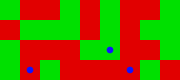

In [94]:
mark_triad_and_instrument(example_bits, [0,0])

In [99]:
instrument_from_triad_coord(example_bits, [0,0])

[1, 0, 0]

### Timing

The original CAMUS protocol had an incomplete collection of "temporal morphologies" i.e. timing templates indicating when each voice of the triad starts and stops in the bar. We expand on that here in the following way:
 - `a` indicates whether the bottom note of the triad starts on the first beat of the bar or waits a little
 - `b` indicates whether the middle note of the triad starts on the first beat of the bar or waits a little
 - `c` indicates whether the upper note of the triad starts on the first beat of the bar or waits a little
 - `d` determines how long the wait is. If `1` then wait a quaver, if `0` then wait a crotchet
 

Similarly we use `mnop` for the timings at the end of the bar:

 - `m` indicates whether the bottom note of the triad goes to the end of the bar or finishes early 
 - `n` indicates whether the middle note of the triad goes to the end of the bar or finishes early
 - `o` indicates whether the upper note of the triad goes to the end of the bar or finishes early
 - `p` determines what _finishes early_ means. If `1` then a quaver early, if `0` then a crotchet early

Using dark bars to indicate note placement and duration here is a diagram showing how the values in neighbouring cells affect the timings of the notes played.

![How to determine timings under CAMUS](images/timings_CAMUS.svg)

In [100]:
def timings(bits, triad_coord, short_wait=0.5, long_wait=1):
    """Given a triad coordinate find the lengths of the rests (if any) before and after the part is played.
    
    `short_wait` is the length of the rest if the appropriate cell's value is `1`,
    and `long_wait` is the length of the rest if the appropriate cell's value is `0`.
    
    `offset` is used when concatenating data, and shifts all timings the specified amount.
    """
    n = neighbours(bits, [triad_coord[0]+1, triad_coord[1]])
    entry = [n[direction] * (short_wait if n["d"] else long_wait) for direction in "abc"]
    exit = [n[direction] * (short_wait if n["p"] else long_wait) for direction in "mno"]
    return {"entry": entry, "exit": exit }

Remember that triad bit coordinates are shifted over by one from general grid coordinates.

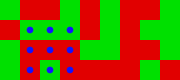

In [101]:
draw_neighbours(example_bits,[2,1])

In [102]:
timings(example_bits, [1,1])

{'entry': [1, 1, 0], 'exit': [1, 0, 1]}

### Putting it together (bit by bit)

We now have everything we need to start making music, so let's gather it all into one place.

In [103]:
def bits_to_triad_sequence(bits):
    """From a grid of bits make a list of triads with instrumentation and timing information included.
    """
    breakdown = bit_breakdown(bits)
    fundamental = breakdown_to_semitone_shift(breakdown["fundamental"])
    triad_coordinates = triad_bits_to_coordinate_sequence(breakdown["triads"])
    triad_data = [{"intervals": intervals_to_triad(fundamental, coordinate),
                  "instruments": instrument_from_triad_coord(bits, coordinate),
                  "timings": timings(bits, coordinate)}
                  for coordinate in triad_coordinates] 
    return triad_data

In [104]:
bits_to_triad_sequence(example_bits)

[{'intervals': [13, 14, 14],
  'instruments': [0, 0, 1],
  'timings': {'entry': [0, 0, 0], 'exit': [0, 0, 0]}},
 {'intervals': [13, 16, 17],
  'instruments': [1, 0, 0],
  'timings': {'entry': [0, 0, 1], 'exit': [1, 0, 1]}},
 {'intervals': [13, 13, 15],
  'instruments': [1, 1, 0],
  'timings': {'entry': [0, 0, 1], 'exit': [0.5, 0.0, 0.0]}},
 {'intervals': [13, 14, 16],
  'instruments': [0, 0, 1],
  'timings': {'entry': [0.0, 0.0, 0.5], 'exit': [0, 0, 1]}},
 {'intervals': [13, 15, 17],
  'instruments': [0, 0, 1],
  'timings': {'entry': [0.5, 0.0, 0.0], 'exit': [0, 1, 0]}},
 {'intervals': [13, 15, 18],
  'instruments': [0, 1, 1],
  'timings': {'entry': [0, 1, 0], 'exit': [0.0, 0.0, 0.0]}}]

### Sequence of bit grids

We will want to be able to chain bit grids together into one long composition.

In [105]:
def sequence_of_bit_grids_to_triads(list_of_bit_grids):
    return [triad 
            for bits in list_of_bit_grids
            for triad in bits_to_triad_sequence(bits)]

Here's how to produce triad data from inputting the same example bits twice.

In [106]:
sequence_of_bit_grids_to_triads([example_bits, example_bits])

[{'intervals': [13, 14, 14],
  'instruments': [0, 0, 1],
  'timings': {'entry': [0, 0, 0], 'exit': [0, 0, 0]}},
 {'intervals': [13, 16, 17],
  'instruments': [1, 0, 0],
  'timings': {'entry': [0, 0, 1], 'exit': [1, 0, 1]}},
 {'intervals': [13, 13, 15],
  'instruments': [1, 1, 0],
  'timings': {'entry': [0, 0, 1], 'exit': [0.5, 0.0, 0.0]}},
 {'intervals': [13, 14, 16],
  'instruments': [0, 0, 1],
  'timings': {'entry': [0.0, 0.0, 0.5], 'exit': [0, 0, 1]}},
 {'intervals': [13, 15, 17],
  'instruments': [0, 0, 1],
  'timings': {'entry': [0.5, 0.0, 0.0], 'exit': [0, 1, 0]}},
 {'intervals': [13, 15, 18],
  'instruments': [0, 1, 1],
  'timings': {'entry': [0, 1, 0], 'exit': [0.0, 0.0, 0.0]}},
 {'intervals': [13, 14, 14],
  'instruments': [0, 0, 1],
  'timings': {'entry': [0, 0, 0], 'exit': [0, 0, 0]}},
 {'intervals': [13, 16, 17],
  'instruments': [1, 0, 0],
  'timings': {'entry': [0, 0, 1], 'exit': [1, 0, 1]}},
 {'intervals': [13, 13, 15],
  'instruments': [1, 1, 0],
  'timings': {'entry': 

### Putting it together (part by part)

The above data is segmented into triads, but we would rather have this data by _instrument_ for turning it into MIDI.

In [107]:
def triads_to_instrument_parts(triad_data, offset = 0):
    """From a grid of bits construct instructions for each instrument part.
    
    `offset`: shift all timings by the specified amount.
    """
    instruments = [[],[]]
    for index, triad in enumerate(triad_data):
        for part in [0,1,2]:
            instruments[triad["instruments"][part]].append({
                "pitch": triad["intervals"][part],
                "entry": offset + index*3 + triad["timings"]["entry"][part],
                "exit": offset + (index+1)*3 - triad["timings"]["exit"][part]
            })
    return instruments

In [47]:
triads_to_instrument_parts(bits_to_triad_sequence(example_bits))

[[{'pitch': 11, 'entry': 0.0, 'exit': 3},
  {'pitch': 12, 'entry': 3.0, 'exit': 6},
  {'pitch': 14, 'entry': 7, 'exit': 8.5},
  {'pitch': 14, 'entry': 7, 'exit': 9.0},
  {'pitch': 11, 'entry': 9, 'exit': 11.5},
  {'pitch': 13, 'entry': 10, 'exit': 11.5},
  {'pitch': 14, 'entry': 12.5, 'exit': 15.0},
  {'pitch': 15, 'entry': 12.5, 'exit': 14.5},
  {'pitch': 14, 'entry': 16, 'exit': 17},
  {'pitch': 11, 'entry': 18.5, 'exit': 21.0},
  {'pitch': 13, 'entry': 18.0, 'exit': 20.5},
  {'pitch': 14, 'entry': 21.5, 'exit': 23},
  {'pitch': 16, 'entry': 21.0, 'exit': 23},
  {'pitch': 15, 'entry': 24, 'exit': 26},
  {'pitch': 14, 'entry': 27, 'exit': 30},
  {'pitch': 17, 'entry': 28, 'exit': 30}],
 [{'pitch': 11, 'entry': 0.0, 'exit': 3},
  {'pitch': 11, 'entry': 0.5, 'exit': 3},
  {'pitch': 11, 'entry': 3.0, 'exit': 6},
  {'pitch': 12, 'entry': 3.0, 'exit': 5},
  {'pitch': 11, 'entry': 6, 'exit': 9.0},
  {'pitch': 14, 'entry': 10, 'exit': 11.5},
  {'pitch': 11, 'entry': 12.5, 'exit': 15.0},
  {'

In [108]:
def triads_to_voice_parts(triad_data):
    """From a grid of bits construct instructions for each instrument part.
    
    `offset`: shift all timings by the specified amount.
    """
    voices = [[],[],[]]
    for index, triad in enumerate(triad_data):
        for voice in [0,1,2]:
            voices[voice].append({
                "pitch": triad["intervals"][voice],
                "entry": index*3 + triad["timings"]["entry"][voice],
                "exit": (index+1)*3 - triad["timings"]["exit"][voice],
                "instrument": triad["instruments"][voice]
            })
    return voices

In [109]:
triads_to_voice_parts(bits_to_triad_sequence(example_bits))

[[{'pitch': 13, 'entry': 0, 'exit': 3, 'instrument': 0},
  {'pitch': 13, 'entry': 3, 'exit': 5, 'instrument': 1},
  {'pitch': 13, 'entry': 6, 'exit': 8.5, 'instrument': 1},
  {'pitch': 13, 'entry': 9.0, 'exit': 12, 'instrument': 0},
  {'pitch': 13, 'entry': 12.5, 'exit': 15, 'instrument': 0},
  {'pitch': 13, 'entry': 15, 'exit': 18.0, 'instrument': 0}],
 [{'pitch': 14, 'entry': 0, 'exit': 3, 'instrument': 0},
  {'pitch': 16, 'entry': 3, 'exit': 6, 'instrument': 0},
  {'pitch': 13, 'entry': 6, 'exit': 9.0, 'instrument': 1},
  {'pitch': 14, 'entry': 9.0, 'exit': 12, 'instrument': 0},
  {'pitch': 15, 'entry': 12.0, 'exit': 14, 'instrument': 0},
  {'pitch': 15, 'entry': 16, 'exit': 18.0, 'instrument': 1}],
 [{'pitch': 14, 'entry': 0, 'exit': 3, 'instrument': 1},
  {'pitch': 17, 'entry': 4, 'exit': 5, 'instrument': 0},
  {'pitch': 15, 'entry': 7, 'exit': 9.0, 'instrument': 0},
  {'pitch': 16, 'entry': 9.5, 'exit': 11, 'instrument': 1},
  {'pitch': 17, 'entry': 12.0, 'exit': 15, 'instrument'

# Making Music

Now we turn all of the information above into music. We will actually want the following ways of representing our music:
 - Split by instrument
 - Split by voice (low, middle, high)

We will want to be able to save this information in the following formats:
 - A MIDI file, with instruments specified
 - MusicXML format

In [110]:
# This is the default instrumentation the composition will use, unless you override it in the function calls
instrumentation = (music21.instrument.Vibraphone, music21.instrument.Marimba)

### Streams split by instrument

We have been using numbers to represent notes, so here is a function that turns a number (representing the number of semitones above low C) into its MIDI name.

In [111]:
import musical_scales
def int_to_midi(note_int, shift = 0):
    """Get the note name from a specification of semitones above middle C.
    
    Use the `shift` parameter to transpose the entire piece that many semitones up.
    For example use `shift = -12` to transpose the piece down an octave.
    """
    return musical_scales.Note(semitones_above_middle_c=note_int+12 + shift).midi

In [112]:
def bit_grid_to_chord_sequence_with_instruments_stream(triad_sequence, instruments=instrumentation):
    """Construct a stream as two parts, one for each instrument."""
    instrument_parts = triads_to_instrument_parts(triad_sequence)

    piece_length_in_beats = max(map(lambda note: note["exit"], [note
                                                                for part in instrument_parts
                                                                for note in part]))
    piece_length_in_bars = math.ceil(piece_length_in_beats / 3)

    def notes_in_bar(notes, bar):
        """Only those notes that sound in the given bar."""
        return [note for note in notes if note["entry"] >= bar*3 and note["exit"] <= (bar+1)*3]

    def notes_playing_at_time(notes, time):
        """Only those notes that sound in the given bar."""
        return [note for note in notes if note["entry"] <= time and note["exit"] > time]
    stream = music21.stream.Stream()
    stream.insert(0, music21.layout.ScoreLayout(isNew=True))
    parts = []
    for instrument_index, instrument in enumerate([instruments[0](), instruments[1]()]):
        notes_for_this_instrument = instrument_parts[instrument_index]
        part = music21.stream.Part(str(instrument))

        for bar in range(piece_length_in_bars):
            measure = music21.stream.Measure(number=bar)
            
            if bar == 0:
                measure.insert(0, instrument)
                measure.insert(0, music21.meter.TimeSignature('3/4'))
            relevant_notes = notes_in_bar(notes_for_this_instrument, bar)
            event_timings = sorted([note["entry"] for note in relevant_notes] +
                                   [note["exit"] for note in relevant_notes] +
                                   [bar*3, (bar+1)*3])

            timings_and_durations = []
            for index in range(len(event_timings) - 1):
                timings_and_durations.append(
                    (event_timings[index], event_timings[index+1] - event_timings[index]))
            
            # Need to keep handles on the generated chords so we can add ties
            chords_in_this_bar = []
            for timing, duration in timings_and_durations:
                if duration > 0:
                    notes_playing = notes_playing_at_time(
                        relevant_notes, timing)
                    music21_duration = music21.duration.Duration(duration)
                    if len(notes_playing) == 0:
                        measure.insert(timing - 3*bar, music21.note.Rest(
                            duration=music21_duration))
                    else:
                        pitches = [int_to_midi(note["pitch"]) for note in notes_playing]
                        chord = music21.chord.Chord(pitches, duration=music21_duration)
                        chords_in_this_bar.append(chord)
                        measure.insert(timing - 3*bar, chord)
                        
                        
            # Add the ties to the chords
            if len(chords_in_this_bar) < 2:
                pass
            else:
                # Set everything to a "continue" tie, then overwrite the first and final chords
                for n in range(len(chords_in_this_bar)):
                    chords_in_this_bar[n].tie = music21.tie.Tie("continue")
                chords_in_this_bar[0].tie = music21.tie.Tie("start")
                chords_in_this_bar[-1].tie = music21.tie.Tie("stop")
            
            # Add the bar to the part
            part.insert(3*bar, measure)
            
        parts.append(part)
        
    # Add the parts to the stream
    for part in parts:
        stream.insert(0, part)
        
    # Tell the stream to band the parts together
    stream.insert(0, music21.layout.StaffGroup(parts, symbol="brace"))
    
    return stream


### Streams split by voice

In [113]:
def bit_grid_to_voices_stream(triad_sequence, instruments = []):
    """Construct a stream as three voices, ignoring instrument information."""
    stream = music21.stream.Score()
    stream.insert(0, music21.layout.ScoreLayout(isNew=True))
    
    parts = [music21.stream.Part() for i in range(3)]
    
    for index, instrument in enumerate(instruments):
        parts[index].insert(0, instrument())
    
    for index, triad in enumerate(triad_sequence):
        measures = [music21.stream.Measure(number=index) for i in range(3)]
        if index == 0:
            for m_index, measure in enumerate(measures):
                measure.insert(0, music21.meter.TimeSignature('3/4'))
        for voice in [0,1,2]:
            instrument_index = triad["instruments"][voice]
            entry = triad["timings"]["entry"][voice]
            if entry > 0:
                measures[voice].insert(0, music21.note.Rest(duration=music21.duration.Duration(entry)))
            exit = triad["timings"]["exit"][voice]
            note = music21.note.Note(int_to_midi(triad["intervals"][voice]),
                                     duration=music21.duration.Duration(3-exit-entry))
            measures[voice].insert(entry, note)
            if exit > 0:
                measures[voice].insert(3-exit, music21.note.Rest(duration=music21.duration.Duration(exit)))
        [parts[i].insert(3*index, measures[i]) for i in range(3)]
        
    for part in parts:
        stream.insert(0, part)
    stream.insert(0, music21.layout.StaffGroup(parts, symbol="brace"))
    return stream

## Making OSC

### Instrumentation as specified by CAMUS

In [126]:
def bit_grids_to_midi_instrumentation_from_CAMUS(list_of_bit_grids, shift=0, tempo=120, instruments = instrumentation):
    """Save a MIDI file, instrumentation determined by CAMUS.
    
    filename: Name of the saved MIDI file
    shift: Transpose the piece that many semitonrs
    tempo: Tempo
    instruments: The two instruments that CAMUS can use
    """
    #midiFile = midiutil.MIDIFile(len(instrumentation)) # 1 track
    
    
    instrument_parts = triads_to_instrument_parts(sequence_of_bit_grids_to_triads(list_of_bit_grids))
    
    
    for instrument, instrument_part in enumerate(instrument_parts):
        midiFile.addTempo(instrument,0,tempo)
        midiFile.addProgramChange(instrument, 0, entry, instrument)
        for note in instrument_part:
            pitch = note["pitch"] + 42 + shift
            #instrument =  instruments[note["instrument"]]().midiProgram
            entry = float(note["entry"])
            duration = float(note["exit"] - note["entry"])
            if duration > 0:
                midiFile.addProgramChange(instrument, 0, entry, instrument)
                midiFile.addNote(instrument, 0, pitch, entry, duration, 100)
    
    with open(filename, "wb") as output_file:
        midiFile.writeFile(output_file)

In [155]:
list(musical_scales.scale_intervals.values())
#*math.pow(2,1/12)

[[2, 2, 2, 1, 2, 1, 2],
 [2, 1, 2, 2, 1, 2, 2],
 [2, 1, 3, 1, 1, 3, 1, 2, 1, 2],
 [1, 2, 1, 2, 2, 2, 2],
 [3, 1, 3, 1, 3, 1],
 [2, 2, 1, 2, 2, 1, 1, 1],
 [3, 2, 1, 1, 3, 2],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 1, 2, 2, 2, 1, 2],
 [1, 3, 1, 2, 1, 3, 1],
 [1, 3, 2, 2, 2, 1, 1],
 [1, 3, 1, 2, 1, 3, 1],
 [2, 1, 3, 1, 1, 2, 2],
 [2, 1, 2, 1, 2, 2, 2],
 [2, 2, 1, 2, 1, 3, 1],
 [2, 1, 2, 2, 1, 3, 1],
 [4, 2, 1, 4, 1],
 [2, 1, 3, 1, 1, 3, 1],
 [3, 1, 2, 1, 2, 1, 2],
 [1, 4, 2, 1, 4],
 [1, 4, 2, 3, 2],
 [2, 2, 1, 2, 2, 2, 1],
 [1, 4, 1, 4, 2],
 [1, 2, 2, 1, 2, 2, 2],
 [2, 2, 2, 2, 1, 2, 1],
 [2, 2, 2, 1, 2, 2, 1],
 [2, 2, 1, 1, 2, 2, 2],
 [2, 2, 3, 2, 3],
 [2, 1, 2, 2, 2, 2, 1],
 [2, 1, 2, 2, 2, 2, 1],
 [3, 2, 2, 3, 2],
 [2, 2, 1, 2, 2, 1, 2],
 [1, 2, 2, 2, 2, 2, 1],
 [1, 2, 2, 2, 1, 3, 1],
 [2, 1, 2, 1, 2, 1, 2, 1],
 [1, 2, 1, 2, 1, 2, 1],
 [1, 3, 1, 1, 2, 3, 1],
 [1, 3, 1, 2, 1, 2, 2],
 [1, 2, 2, 2, 1, 2, 2],
 [2, 2, 2, 3, 1, 2],
 [3, 1, 1, 2, 2, 3],
 [1, 3, 2, 1, 3, 2],
 [1, 1, 4, 1,

In [138]:
for triad in sequence_of_bit_grids_to_triads([example_bits, example_bits]):
    print(triad['intervals'])

[13, 14, 14]
[13, 16, 17]
[13, 13, 15]
[13, 14, 16]
[13, 15, 17]
[13, 15, 18]
[13, 14, 14]
[13, 16, 17]
[13, 13, 15]
[13, 14, 16]
[13, 15, 17]
[13, 15, 18]


In [135]:
instrument_parts = triads_to_instrument_parts(sequence_of_bit_grids_to_triads([example_bits, example_bits]))
instrument_parts

[[{'pitch': 13, 'entry': 0, 'exit': 3},
  {'pitch': 14, 'entry': 0, 'exit': 3},
  {'pitch': 16, 'entry': 3, 'exit': 6},
  {'pitch': 17, 'entry': 4, 'exit': 5},
  {'pitch': 15, 'entry': 7, 'exit': 9.0},
  {'pitch': 13, 'entry': 9.0, 'exit': 12},
  {'pitch': 14, 'entry': 9.0, 'exit': 12},
  {'pitch': 13, 'entry': 12.5, 'exit': 15},
  {'pitch': 15, 'entry': 12.0, 'exit': 14},
  {'pitch': 13, 'entry': 15, 'exit': 18.0},
  {'pitch': 13, 'entry': 18, 'exit': 21},
  {'pitch': 14, 'entry': 18, 'exit': 21},
  {'pitch': 16, 'entry': 21, 'exit': 24},
  {'pitch': 17, 'entry': 22, 'exit': 23},
  {'pitch': 15, 'entry': 25, 'exit': 27.0},
  {'pitch': 13, 'entry': 27.0, 'exit': 30},
  {'pitch': 14, 'entry': 27.0, 'exit': 30},
  {'pitch': 13, 'entry': 30.5, 'exit': 33},
  {'pitch': 15, 'entry': 30.0, 'exit': 32},
  {'pitch': 13, 'entry': 33, 'exit': 36.0}],
 [{'pitch': 14, 'entry': 0, 'exit': 3},
  {'pitch': 13, 'entry': 3, 'exit': 5},
  {'pitch': 13, 'entry': 6, 'exit': 8.5},
  {'pitch': 13, 'entry': 

In [ ]:
from pythonosc import udp_client

# Set up the OSC client
ip = "127.0.0.1"  # SuperCollider's IP address (localhost in this case)
port = 57120  # SuperCollider's default OSC port
client = udp_client.SimpleUDPClient(ip, port)

# Define the OSC message
address = "/some/address"  # The OSC address in SuperCollider
arg1 = 1  # First argument
arg2 = 2  # Second argument
arg3 = "hello"  # Third argument
arg4 = 3.14  # Fourth argument

# Send the OSC message
client.send_message(address, [arg1, arg2, arg3, arg4])


In [127]:
bit_grids_to_midi_instrumentation_from_CAMUS([example_bits])

IndexError: pop from empty list

### Each voice given a different instrument

In [130]:
def bit_grids_to_midi_instrumentation_by_voice(list_of_bit_grids, instruments, filename="temp.midi", shift=0, tempo=120):
    """Save a MIDI file, instrumetnation determined by voice.
    
    instruments: The three isntruments to use, one per voice
    filename: Name of the saved MIDI file
    shift: Transpose the piece that many semitonrs
    tempo: Tempo
    """
    midiFile = midiutil.MIDIFile(1,file_format=1) # 1 track
    midiFile.addTempo(0,0,tempo)
    
    voice_parts = triads_to_voice_parts(sequence_of_bit_grids_to_triads(list_of_bit_grids))
    
    
    for voice, voice_part in enumerate(voice_parts):
        
        for note in voice_part:
            pitch = note["pitch"] + 42 + shift
            instrument =  instruments[voice]().midiProgram
            entry = float(note["entry"])
            duration = float(note["exit"] - note["entry"])
            if duration > 0:
                midiFile.addProgramChange(0, voice, entry, instrument)
                midiFile.addNote(0, voice, pitch, entry, duration, 100)
    
    with open(filename, "wb") as output_file:
        midiFile.writeFile(output_file)

In [119]:
a = midiutil.MIDIFile(3)
a.writeFile

TypeError: 'MIDIFile' object is not subscriptable

In [131]:
bit_grids_to_midi_instrumentation_by_voice([example_bits], [music21.instrument.Piano, music21.instrument.Xylophone, music21.instrument.Marimba])

### Summary of creating outputs

Creating MusicXML:
 - `save_musicxml(bit_grid_to_voices_stream(example_bits), "voices.xml")` - one instrument per voice, defaults to "temp.xml"
 - `save_musicxml(bit_grid_to_chord_sequence_with_instruments_stream(example_bits))` - instruments determined by CAMUS, defaults to "temp.xml"

Creating MIDI:
 - `bit_grid_to_midi_instrumentation_from_CAMUS(example_bits)` - instruments determined by CAMUS, defaults to "temp.midi"
 - `bit_grid_to_midi_instrumentation_by_voice(example_bits, [music21.instrument.Piano, music21.instrument.Xylophone, music21.instrument.Marimba])` - one instrument per voice, defaults to "temp.midi"

# Making it your own

All that matters in the above is that we start with a grid of bits and end with musical instructions. For example you can:
 - Change the instrumentation by altering the `instruments` argument for `bit_grid_to_chord_sequence`
   - Remember you can write `music21.instrument.` and then press `tab` to see a list of options
   - The list of instruments afforded by `music21` is also found in the right hand side of [this page](http://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html)
   - You can also specify a [MIDI program number](http://www.ccarh.org/courses/253/handout/gminstruments/)
       using `music21.instrument.instrumentFromMidiProgram(number-1)`
 - Change how long the rests are by altering the values of `long_rest` and `short_rest` in the function `timings`
 - Change the default value of the `shift` parameter in `int_to_midi` to transpose your composition up or down

# Making it Quantum

As with the 1D case we will need `pqca` to provide the Automaton, and `qiskit` so we can draw out quantum circuits.

In [63]:
import qiskit

In [167]:
import pqca

Let's start everything in the state where it's all $0$s. Note that the Automaton expects a list of qubits rather than a grid. We encode the grid structure when we describe the update frames later on.

In [65]:
initial_state = [0]*9*4

Rather than describe a circuit that acts on $36$ qubits we will describe two circuits - one that acts on just two qubits (that acts "vertically") and one on three qubits (that acts "horizontally").

![A grid 9 wide and 4 tall split into cells 1 wide and 2 tall](images/vertical_9_by_4.svg)

In [168]:
tes_1 = pqca.tessellation.n_dimensional([9,4],[1,2])

![A grid 9 wide and 4 tall split into cells 3 wide and 1 tall](images/horizontal_9_by_4.svg)

In [169]:
tes_2 = pqca.tessellation.n_dimensional([9,4],[3,1])

In [67]:
tes_2 = pqca.tessellation.n_dimensional([9,4],[3,1])

What should our circuits be? That's up to you! Here are two examples; note that since the automaton state starts in all $0$s you will want at least one gate that sends a $0$ state to something else.

In [68]:
two_qubit_circuit = qiskit.QuantumCircuit(2)
two_qubit_circuit.cx(0,1)
two_qubit_circuit.h(0)
two_qubit_circuit.draw()

┌───┐
q_0: ──■──┤ H ├
     ┌─┴─┐└───┘
q_1: ┤ X ├─────
     └───┘

In [69]:
three_qubit_circuit = qiskit.QuantumCircuit(3)
three_qubit_circuit.cx(0,1)
three_qubit_circuit.x(1)
three_qubit_circuit.cx(1,2)
three_qubit_circuit.draw()

q_0: ──■────────────
     ┌─┴─┐┌───┐     
q_1: ┤ X ├┤ X ├──■──
     └───┘└───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

Now to put this all together; remember that an Update Frame is a tessellation of the qubits into cells, and a circuit that acts on each cell.

In [70]:
update_frame_1 = pqca.UpdateFrame(tes_1, qiskit_circuit=two_qubit_circuit)

In [71]:
update_frame_2 = pqca.UpdateFrame(tes_2,  qiskit_circuit=three_qubit_circuit)

And we combine this with the Aer qiskit simulator backend to apply our big circuit to the current state.

In [72]:
automaton = pqca.Automaton(initial_state, [update_frame_1, update_frame_2], pqca.backend.qiskit())

Just how big is this update circuit?

In [73]:
automaton.update_circuit.draw()

┌───┐                                        
 q_0: ──■──┤ H ├────────────■───────────────────────────
      ┌─┴─┐└───┘            │                           
 q_1: ┤ X ├───────■─────────┼───────────────────────────
      └───┘┌───┐  │         │                           
 q_2: ──■──┤ H ├──┼─────────┼────■──────────────────────
      ┌─┴─┐└───┘  │         │    │                      
 q_3: ┤ X ├───────┼────■────┼────┼──────────────────────
      └───┘┌───┐  │    │  ┌─┴─┐  │  ┌───┐               
 q_4: ──■──┤ H ├──┼────┼──┤ X ├──┼──┤ X ├───────■───────
      ┌─┴─┐└───┘┌─┴─┐  │  ├───┤  │  └───┘       │       
 q_5: ┤ X ├─────┤ X ├──┼──┤ X ├──┼────■─────────┼───────
      └───┘┌───┐└───┘  │  └───┘┌─┴─┐  │  ┌───┐  │       
 q_6: ──■──┤ H ├───────┼───────┤ X ├──┼──┤ X ├──┼────■──
      ┌─┴─┐└───┘     ┌─┴─┐┌───┐└───┘  │  └───┘  │    │  
 q_7: ┤ X ├──────────┤ X ├┤ X ├──■────┼─────────┼────┼──
      └───┘┌───┐     └───┘└───┘  │    │       ┌─┴─┐  │  
 q_8: ──■──┤ H ├─────────────────┼────┼───────┤ X ├──┼──
      ┌─┴─┐└───┘                 │  ┌─┴─┐     └───┘  │  
 q_9: ┤ X ├──────────────────────┼──┤ X ├────────────┼──
      └───┘┌───┐                 │  └───┘          ┌─┴─┐
q_10: ──■──┤ H ├─────────────────┼─────────────────┤ X ├
      ┌─┴─┐└───┘               ┌─┴─┐               └───┘
q_11: ┤ X ├────────────────────┤ X ├────────────────────
      └───┘┌───┐               └───┘                    
q_12: ──■──┤ H ├────────────■───────────────────────────
      ┌─┴─┐└───┘            │                           
q_13: ┤ X ├───────■─────────┼───────────────────────────
      └───┘┌───┐  │         │                           
q_14: ──■──┤ H ├──┼─────────┼────■──────────────────────
      ┌─┴─┐└───┘  │         │    │                      
q_15: ┤ X ├───────┼────■────┼────┼──────────────────────
      └───┘┌───┐  │    │  ┌─┴─┐  │  ┌───┐               
q_16: ──■──┤ H ├──┼────┼──┤ X ├──┼──┤ X ├───────■───────
      ┌─┴─┐└───┘┌─┴─┐  │  ├───┤  │  └───┘       │       
q_17: ┤ X ├─────┤ X ├──┼──┤ X ├──┼────■─────────┼───────
      └───┘┌───┐└───┘  │  └───┘┌─┴─┐  │  ┌───┐  │       
q_18: ──■──┤ H ├───────┼───────┤ X ├──┼──┤ X ├──┼────■──
      ┌─┴─┐└───┘     ┌─┴─┐┌───┐└───┘  │  └───┘  │    │  
q_19: ┤ X ├──────────┤ X ├┤ X ├──■────┼─────────┼────┼──
      └───┘┌───┐     └───┘└───┘  │    │       ┌─┴─┐  │  
q_20: ──■──┤ H ├─────────────────┼────┼───────┤ X ├──┼──
      ┌─┴─┐└───┘                 │  ┌─┴─┐     └───┘  │  
q_21: ┤ X ├──────────────────────┼──┤ X ├────────────┼──
      └───┘┌───┐                 │  └───┘          ┌─┴─┐
q_22: ──■──┤ H ├─────────────────┼─────────────────┤ X ├
      ┌─┴─┐└───┘               ┌─┴─┐               └───┘
q_23: ┤ X ├────────────────────┤ X ├────────────────────
      └───┘┌───┐               └───┘                    
q_24: ──■──┤ H ├────────────■───────────────────────────
      ┌─┴─┐└───┘            │                           
q_25: ┤ X ├───────■─────────┼───────────────────────────
      └───┘┌───┐  │         │                           
q_26: ──■──┤ H ├──┼─────────┼────■──────────────────────
      ┌─┴─┐└───┘  │         │    │                      
q_27: ┤ X ├───────┼────■────┼────┼──────────────────────
      └───┘┌───┐  │    │  ┌─┴─┐  │  ┌───┐               
q_28: ──■──┤ H ├──┼────┼──┤ X ├──┼──┤ X ├───────■───────
      ┌─┴─┐└───┘┌─┴─┐  │  ├───┤  │  └───┘       │       
q_29: ┤ X ├─────┤ X ├──┼──┤ X ├──┼────■─────────┼───────
      └───┘┌───┐└───┘  │  └───┘┌─┴─┐  │  ┌───┐  │       
q_30: ──■──┤ H ├───────┼───────┤ X ├──┼──┤ X ├──┼────■──
      ┌─┴─┐└───┘     ┌─┴─┐┌───┐└───┘  │  └───┘  │    │  
q_31: ┤ X ├──────────┤ X ├┤ X ├──■────┼─────────┼────┼──
      └───┘┌───┐     └───┘└───┘  │    │       ┌─┴─┐  │  
q_32: ──■──┤ H ├─────────────────┼────┼───────┤ X ├──┼──
      ┌─┴─┐└───┘                 │  ┌─┴─┐     └───┘  │  
q_33: ┤ X ├──────────────────────┼──┤ X ├────────────┼──
      └───┘┌───┐                 │  └───┘          ┌─┴─┐
q_34: ──■──┤ H ├─────────────────┼─────────────────┤ X ├
      ┌─┴─┐└───┘     

That's bigger than I, personally, would like to write out by hand. The automaton handles all the repeated structure for us.

## Plugging the automaton into the composer

At the end of the day what we really want is music, and for that we want a grid of bits to pass to our `compose` function.

In [74]:
class Qubit_Generator:
    def __next__(self):
        thirty_six_bits = next(automaton)
        return [[thirty_six_bits[i+j] for j in range(9)] for i in range(4)]
QBG = Qubit_Generator()

Let's check it's the right shape:

In [75]:
bits = next(QBG)
bits

[[1, 0, 0, 0, 1, 1, 0, 1, 1],
 [0, 0, 0, 1, 1, 0, 1, 1, 1],
 [0, 0, 1, 1, 0, 1, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 1, 0, 1]]

Perfect!

In [76]:
bit_grids_to_midi_instrumentation_from_CAMUS([bits])

There we have it! Stored in `temp.midi` you should have the midi generated by your quantum cellular automaton.

# Visualising the automaton over time

Let's create sequence of grids so we can see how the automaton state changes over time.

In [77]:
import ipywidgets

In [78]:
def visualise_next_n_steps(bit_generator, n):
    cached_states = [next(bit_generator) for _ in range(n)]
    def show_step(iteration):
        return draw_bits(cached_states[iteration])
    return ipywidgets.interact(show_step,iteration=ipywidgets.IntSlider(min=0, max=n-1, step=1, value=0))
visualise_next_n_steps(QBG, 20)
pass

interactive(children=(IntSlider(value=0, description='iteration', max=19), Output()), _dom_classes=('widget-in…

# Iterated composition

We built our MIDI and MusicXML synthesis functions take sequences of bit grids, so let's use this to construct a longer piece from succesive states of the automaton.

In [79]:
bit_grids_to_midi_instrumentation_from_CAMUS([next(QBG) for _ in range(5)])

(Recall that this function defaults to exporting a midi file at `temp.midi`.)

That's it! Thank you for reading this tutorial.

Detailed documentation can be found at [readthedocs.io](https://partitioned-quantum-cellular-automata.readthedocs.io/en/latest/) as well as in the docstrings of the python files themselves. The pqca module and these tutorials are available under the MIT licence, with source code available at [Hector Miller-Bakewell’s github](https://github.com/hmillerbakewell/partitioned-quantum-cellular-automata). This package was created as part of the [QuTune Project](https://iccmr-quantum.github.io/).